In [1]:
import json
import math
import time

import numpy as np
import seaborn as sn
from sklearn.metrics import ConfusionMatrixDisplay

np.random.seed(0)

questions = open('questions.json')
questions = questions.readlines()
np.random.shuffle(questions)
questions = questions[:int(0.2*len(questions))]

In [2]:
def classify_subcategory(text):
    likelihoods = [0 for _ in range(len(SUBCATEGORIES))]
    text = set(removePunctuation(text).lower().split())
    for token in text:
        if token in STOP_WORDS:
            continue

        if token in WORD_TO_SUBCAT:
            for i in range(len(SUBCATEGORIES)):
                likelihoods[i] += math.log(WORD_TO_SUBCAT[token][i] + 0.00000001)
        else:
            # print('Token not in word-to-subcat:', token)
            pass

    max_likelihood = max(likelihoods)
    # as far as I can tell, there's always only one valid index
    valid_indices = [i for i, likelihood in enumerate(likelihoods) if likelihood == max_likelihood]
    return SUBCATEGORIES[np.random.choice(valid_indices)]


def hhi(arr):
    return sum([_**2 for _ in arr]) / sum(arr) ** 2


def normalized_hhi(arr):
    return (hhi(arr) - 1/len(arr)) / (1 - 1/len(arr))


def removePunctuation(s, punctuation='''.,!-;:'"\/?@#$%^&*_~()[]{}“”‘’'''):
    return ''.join(ch for ch in s if ch not in punctuation)


with open('../stop-words.txt') as f:
    STOP_WORDS = set(f.readlines())
    STOP_WORDS = set([word.strip() for word in STOP_WORDS])

with open('../subcategories.txt') as f:
    SUBCATEGORIES = [line.strip() for line in f.readlines()]

time_now = time.perf_counter()

with open('word-to-subcat-normalized.json') as f:
    WORD_TO_SUBCAT = json.load(f)

print('Time to load word-to-subcat-normalized:', time.perf_counter() - time_now, 'seconds')

print('=====Begin Testing=====')
time_now = time.perf_counter()

counter = 0
correct = 0
confusion_matrix = [[0 for _ in range(len(SUBCATEGORIES))] for _ in range(len(SUBCATEGORIES))]

for line in questions:
    data = json.loads(line)

    if 'subcategory' not in data:
        continue

    subcategory = data['subcategory']

    if subcategory not in SUBCATEGORIES:
        continue

    counter += 1

    if data['type'] == 'tossup':
        prediction = classify_subcategory(data['question'] + ' ' + data['answer'])

    if data['type'] == 'bonus' and 'parts' in data and len(data['parts']) == 3:
        prediction = classify_subcategory(data['leadin'] + ' ' + ' '.join(data['parts']) + ' ' + ' '.join(data['answers']))

    subcategory_index = SUBCATEGORIES.index(subcategory)
    prediction_index = SUBCATEGORIES.index(prediction)

    confusion_matrix[subcategory_index][prediction_index] += 1

    if subcategory == prediction:
        correct += 1

    if counter % 10000 == 0:
        print(f'{correct}/{counter}')

print('=====End Testing=====')
print(f'Accuracy: {100 * correct / counter}% ({correct}/{counter})')
print(f'Time: {time.perf_counter() - time_now} seconds')


Time to load word-to-subcat-normalized: 1.3760820169991348 seconds
=====Begin Testing=====
7901/10000
15839/20000
23745/30000
=====End Testing=====
Accuracy: 79.13796797991857% (25852/32667)
Time: 17.735386330998153 seconds


In [3]:
for i, subcat in enumerate(SUBCATEGORIES):
    accuracy = 0.0 if sum(confusion_matrix[i]) == 0 else confusion_matrix[i][i] / sum(confusion_matrix[i])
    accuracy = round(100 * accuracy, 2)
    print(f'{subcat + ":":21} {str(confusion_matrix[i][i]) + "/" + str(sum(confusion_matrix[i])):10} ({accuracy}%)')

American Literature:  1603/1929  (83.1%)
British Literature:   1331/1603  (83.03%)
European Literature:  1028/1295  (79.38%)
World Literature:     703/1045   (67.27%)
American History:     1750/2035  (86.0%)
Ancient History:      151/496    (30.44%)
European History:     2147/2410  (89.09%)
World History:        1542/1947  (79.2%)
Biology:              1680/1849  (90.86%)
Chemistry:            1329/1573  (84.49%)
Physics:              1624/1775  (91.49%)
Math:                 348/611    (56.96%)
Other Science:        915/1334   (68.59%)
Visual Fine Arts:     1808/2021  (89.46%)
Auditory Fine Arts:   1822/2055  (88.66%)
Other Fine Arts:      434/1021   (42.51%)
Religion:             1181/1457  (81.06%)
Mythology:            1490/1673  (89.06%)
Philosophy:           1136/1330  (85.41%)
Social Science:       928/1203   (77.14%)
Current Events:       13/364     (3.57%)
Geography:            586/968    (60.54%)
Trash:                303/673    (45.02%)


In [4]:
print('Confusion Matrix:')
for subcat, row in zip(SUBCATEGORIES, confusion_matrix):
    print(f'{subcat:20}', row)

Confusion Matrix:
American Literature  [1603, 74, 57, 38, 51, 0, 18, 11, 0, 1, 2, 0, 3, 15, 8, 4, 1, 9, 17, 6, 0, 1, 10]
British Literature   [110, 1331, 42, 18, 15, 0, 22, 4, 2, 1, 1, 0, 2, 12, 4, 1, 8, 16, 6, 5, 0, 1, 2]
European Literature  [77, 72, 1028, 25, 2, 0, 22, 3, 0, 0, 1, 0, 2, 18, 8, 2, 1, 18, 9, 3, 0, 1, 3]
World Literature     [143, 66, 34, 703, 11, 0, 10, 23, 0, 0, 0, 0, 3, 5, 4, 1, 2, 29, 6, 3, 0, 2, 0]
American History     [42, 9, 1, 2, 1750, 1, 86, 81, 0, 0, 0, 0, 1, 12, 5, 2, 7, 4, 2, 9, 0, 16, 5]
Ancient History      [0, 4, 2, 1, 6, 151, 238, 63, 1, 0, 0, 0, 1, 13, 0, 0, 3, 12, 1, 0, 0, 0, 0]
European History     [14, 21, 8, 1, 59, 16, 2147, 80, 0, 0, 3, 0, 2, 19, 4, 1, 8, 7, 3, 4, 0, 13, 0]
World History        [7, 12, 2, 11, 84, 7, 202, 1542, 4, 0, 2, 0, 1, 7, 2, 2, 15, 11, 1, 8, 1, 23, 3]
Biology              [14, 4, 2, 1, 21, 1, 6, 4, 1680, 38, 13, 1, 24, 5, 4, 1, 1, 3, 1, 14, 0, 7, 4]
Chemistry            [3, 2, 0, 0, 7, 0, 4, 7, 44, 1329, 133, 2, 26, 2, 1, 1,

<AxesSubplot:>

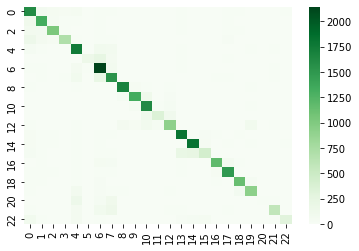

In [5]:
sn.heatmap(confusion_matrix, cmap='Greens', annot=False)

In [6]:
# ConfusionMatrixDisplay(np.array(confusion_matrix), display_labels='').plot()